In [5]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [6]:
words = open('names.txt').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [7]:
len(words)

32033

In [8]:
# building the vocabulary of characters and mappings to/from int

chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
print(itos)


{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [89]:
# building the dataset 

block_size = 3 # context length: bir sonraki karakteri tahmin etmek için kaç karakteri göz önünde bulunduracağız
X, Y = [], []

for w in words:
    #print(w)
    context = [0] * block_size
    for ch in w + '.':
        ix = stoi[ch]
        X.append(context)
        Y.append(ix)
        #print(''.join(itos[i] for i in context),'--->', itos[ix])
        context = context[1:] + [ix] # crop and append

X = torch.tensor(X)
Y = torch.tensor(Y)

In [90]:
X.shape, X.dtype, Y.shape, Y.dtype

(torch.Size([228146, 3]), torch.int64, torch.Size([228146]), torch.int64)

In [172]:
# building the dataset 
def build_dataset(words):
    block_size = 3 # context length: bir sonraki karakteri tahmin etmek için kaç karakteri göz önünde bulunduracağız
    X, Y = [], []
    for w in words:
      
        #print(w)
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            #print(''.join(itos[i] for i in context),'--->', itos[ix])
            context = context[1:] + [ix] # crop and append

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [13]:
C = torch.randn((27,2))

In [25]:
emb = C[X]
emb.shape

torch.Size([32, 3, 2])

In [26]:
W1 = torch.randn((6,100))
b1 = torch.randn(100)

In [55]:
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)

In [56]:
h

tensor([[-0.9977,  0.8794, -0.7786,  ..., -0.9613, -0.9994,  0.8595],
        [-0.9820,  0.8211, -0.7775,  ..., -0.9628, -0.9934,  0.8686],
        [-0.9577,  0.3167,  0.0366,  ..., -0.9870, -0.9497,  0.9811],
        ...,
        [-0.0576, -0.1527, -0.9970,  ...,  0.9778,  0.9788, -0.5029],
        [ 1.0000, -0.5878,  0.9279,  ...,  0.9922,  0.9992, -0.9994],
        [-0.9360, -0.4040,  0.9739,  ..., -0.1530, -0.9984, -0.3576]])

In [57]:
h.shape

torch.Size([32, 100])

In [58]:
W2 = torch.randn((100,27))
b2 = torch.randn(27)

In [59]:
logits = h @ W2 + b2

In [60]:
logits.shape

torch.Size([32, 27])

In [61]:
counts = logits.exp()
prob = counts / counts.sum(1, keepdim=True)

In [63]:
prob.shape

torch.Size([32, 27])

In [70]:
loss = -prob[torch.arange(32), Y].log().mean()
loss

tensor(16.0903)

In [91]:
# -----------rewrite with better visibility------------

In [198]:
Xtr.shape, Ytr.shape #dataset

(torch.Size([182625, 3]), torch.Size([182625]))

In [241]:
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((27,10), generator=g)
W1 = torch.randn((30,200), generator=g)
b1 = torch.randn(200, generator=g)
W2 = torch.randn((200,27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [242]:
sum(p.nelement() for p in parameters) # total number of parameters

11897

In [243]:
for p in parameters:
    p.requires_grad = True

In [244]:
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre

In [245]:
lri = []
lossi = []
stepi = []

In [246]:
for i in range(200000):
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (32,))

    # forward pass
    emb = C[Xtr[ix]] # (32, 3, 2)
    h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
    logits = h @ W2 + b2 # (32, 27)
    loss = F.cross_entropy(logits, Ytr[ix]) # calculate the loss efficiently
    #print(loss.item())

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update the parameters
    # lr = lrs[i]
    lr = 0.1 if i < 10000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    # lri.append(lre[i])
    stepi.append(i)
    lossi.append(loss.log10().item())

#print(loss.item())


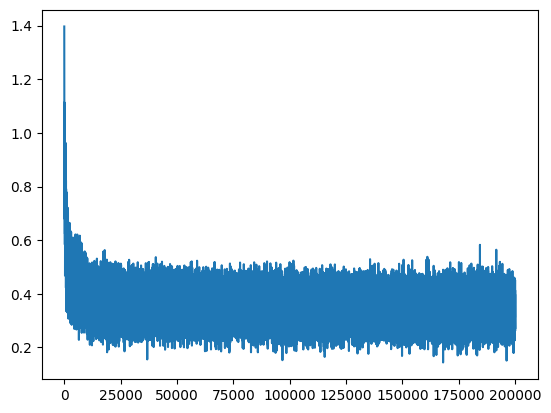

In [247]:
plt.plot(stepi, lossi)

In [248]:
emb = C[Xtr] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ytr) # calculate the loss efficiently
loss

tensor(2.2345, grad_fn=<NllLossBackward0>)

In [249]:
emb = C[Xdev] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ydev) # calculate the loss efficiently
loss

tensor(2.2572, grad_fn=<NllLossBackward0>)

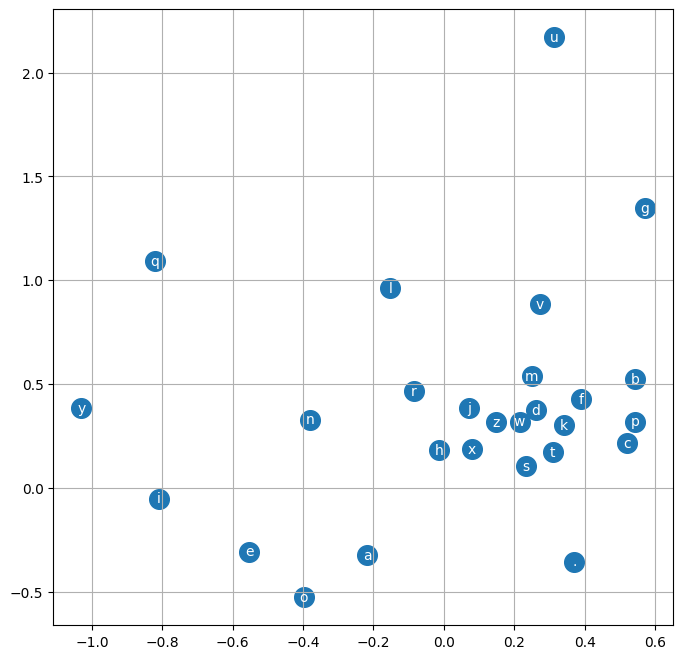

In [217]:
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range (C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha='center', va='center', color='white')
plt.grid('minor')

In [ ]:
# training split, dev/validation split, test split
# 80%, 10%, 10%

# train: used to train the parameters
# validation: used to train the hyperparameters
# test: used to evaluate the model

In [250]:
# sample from model

g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):

    out = []
    context = [0] * block_size # initialize with all
    while True:
        emb = C[torch.tensor([context])] # (1, block_size, d)
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break
    print(''.join(itos[i] for i in out))


mona.
kayah.
see.
mad.
rylle.
emmancendrlee.
adeerdoelin.
shy.
jenre.
elieananar.
kayzion.
kamin.
shdonrgoni.
jest.
jairetel.
panterif.
use.
ged.
raylene.
ehs.
